# 11. 앙상블 - Bagging (배깅)
## 1. 데이터 준비 (Data Preparation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# mobile data 로딩
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv"
data = pd.read_csv(path)

# 불필요한 변수 제거
data.drop(['id', 'REPORTED_USAGE_LEVEL', 'OVER_15MINS_CALLS_PER_MONTH'], axis=1, inplace=True)

# 컬럼명 변경
data.rename(columns={
    'HANDSET_PRICE': 'H_PRICE',
    'AVERAGE_CALL_DURATION': 'DURATION',
    'REPORTED_SATISFACTION': 'SATISFACTION',
    'CONSIDERING_CHANGE_OF_PLAN': 'CHANGE'
}, inplace=True)

# 상위 5개 행 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,H_PRICE,DURATION,SATISFACTION,CHANGE,CHURN
0,0,31953,0,6,313378,161,4,unsat,no,STAY
1,1,36147,0,13,800586,244,6,unsat,considering,STAY
2,1,27273,230,0,305049,201,15,unsat,perhaps,STAY
3,0,120070,38,33,788235,780,2,unsat,considering,LEAVE
4,1,29215,208,85,224784,241,1,very_unsat,never_thought,STAY


In [3]:
# 데이터 분할 1: Target과 Feature 분리
target = 'CHURN'
x = data.drop(target, axis=1)
y = data.loc[:, target]

# 가변수화 (범주형 변수 처리)
dumm_cols = ['SATISFACTION', 'CHANGE']
x = pd.get_dummies(x, columns=dumm_cols, drop_first=True)

# 데이터 분할 2: 학습셋과 검증셋 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.5)

## 2. 모델링 (Modeling)
### Random Forest

In [4]:
# 1) 함수 불러오기
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 2) 모델 선언
model = RandomForestClassifier(n_estimators=5, max_depth=3)

# 3) 학습 (Training)
model.fit(x_train, y_train)

# 4) 예측
pred = model.predict(x_val)

# 5) 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

       LEAVE       0.65      0.69      0.67      4980
        STAY       0.67      0.63      0.65      5020

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



## 3. Random Forest 내부 들여다보기

In [5]:
# 생성된 5개의 Decision Tree 객체 확인
model.estimators_

[DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=2049452538),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=147821397),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1034333180),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1295640754),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1729511256)]

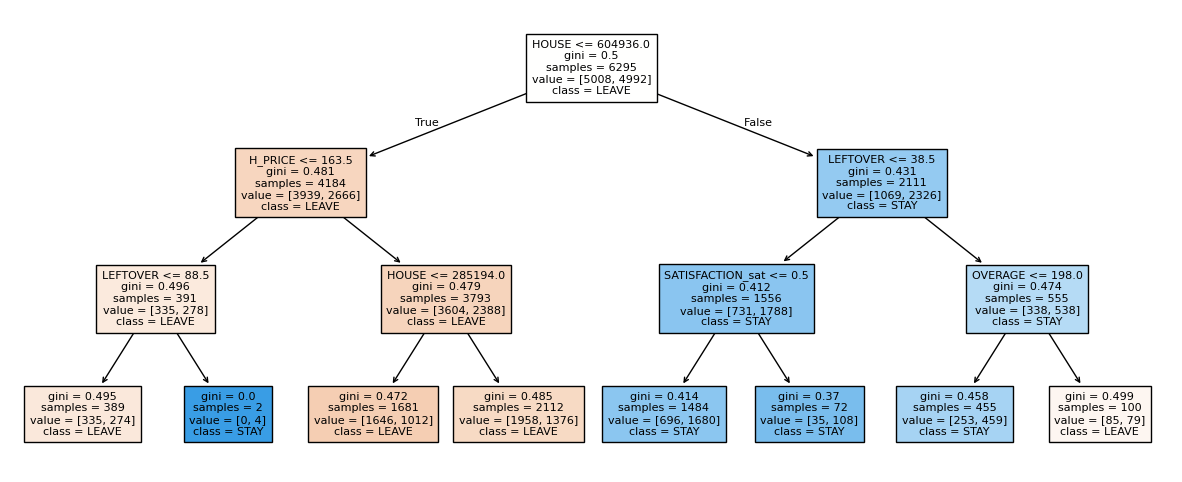

In [6]:
# 첫 번째 트리 시각화
plt.figure(figsize=(15, 6))
plot_tree(model.estimators_[0],
               feature_names=list(x_train.columns),
               class_names=['LEAVE', 'STAY'],
               filled=True, fontsize=8);

### Feature Importance

In [7]:
# 변수 이름과 중요도 수치 출력
print(x_train.columns)
print(model.feature_importances_)

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'H_PRICE',
       'DURATION', 'SATISFACTION_sat', 'SATISFACTION_unsat',
       'SATISFACTION_very_sat', 'SATISFACTION_very_unsat',
       'CHANGE_considering', 'CHANGE_never_thought', 'CHANGE_no',
       'CHANGE_perhaps'],
      dtype='object')
[0.00000000e+00 9.11428742e-02 1.83247315e-01 6.18765347e-02
 4.43755841e-01 1.58075065e-01 5.42595119e-02 1.05562462e-03
 1.99210915e-03 0.00000000e+00 1.02481328e-03 4.14548398e-04
 0.00000000e+00 0.00000000e+00 3.15576229e-03]


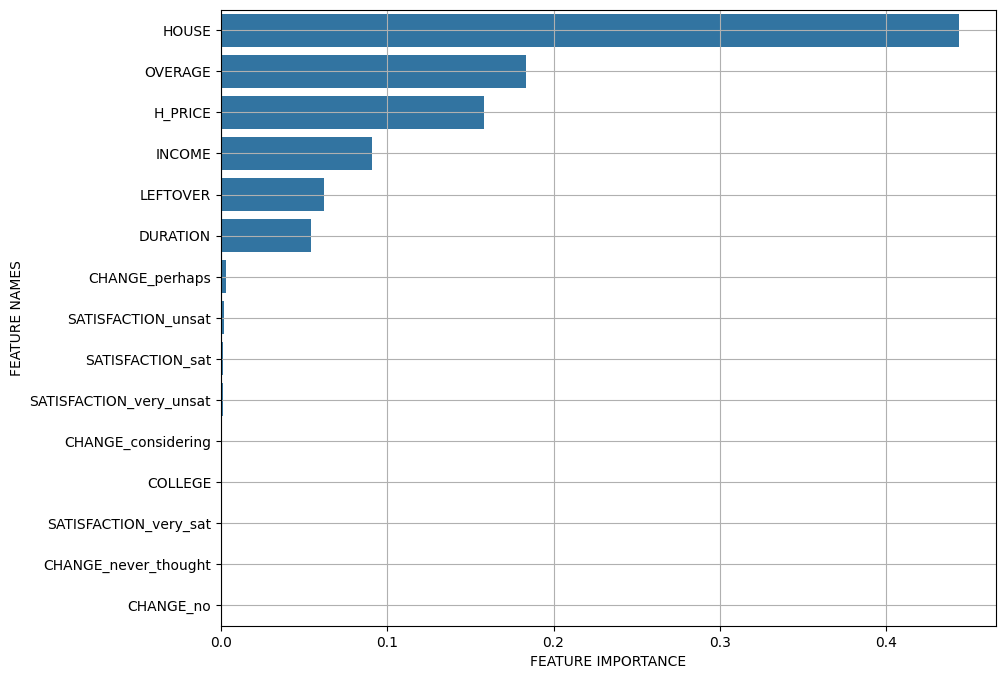

In [8]:
# 변수 중요도 시각화 함수 정의
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # 데이터프레임으로 변환
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # 중요도 순으로 정렬
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    fi_df.reset_index(drop=True, inplace=True)

    # 그래프 그리기
    plt.figure(figsize=(10, 8))
    sns.barplot(x='feature_importance', y='feature_names', data=fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

# 함수 호출
plot_feature_importance(model.feature_importances_, x_train.columns)

## 4. Random Forest 튜닝 (Grid Search)

In [9]:
# 1. 튜닝 파라미터 범위 설정
params = {'n_estimators': range(5, 101, 5), 'max_depth': [3, 5, 7, 9]}

# 2. 함수 불러오기
from sklearn.model_selection import GridSearchCV

# 3. 모델 선언 및 Grid Search 학습
model_gs = GridSearchCV(RandomForestClassifier(), params, cv=5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'n_estimators': range(5, 101, 5)})

In [10]:
# 최적 파라미터와 점수 확인
print(model_gs.best_params_)
print(model_gs.best_score_)

{'max_depth': 7, 'n_estimators': 55}
0.6958


In [11]:
# 튜닝된 모델로 예측 및 평가
pred = model_gs.predict(x_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

       LEAVE       0.70      0.68      0.69      4980
        STAY       0.69      0.71      0.70      5020

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



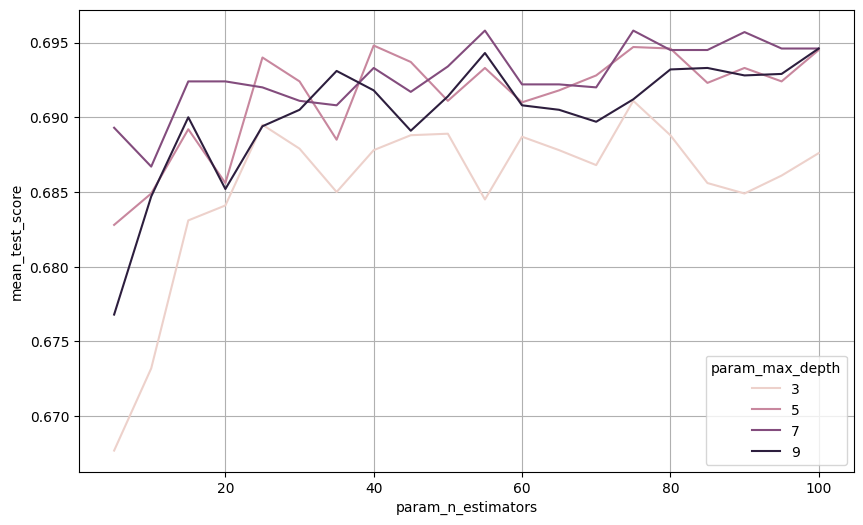

In [12]:
# 결과 데이터프레임 생성
result = pd.DataFrame(model_gs.cv_results_)
result = result[['param_max_depth', 'param_n_estimators', 'mean_test_score']]

# 라인 차트로 시각화 (Hue: max_depth)
plt.figure(figsize=(10, 6))
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=result, hue='param_max_depth')
plt.grid()
plt.show()

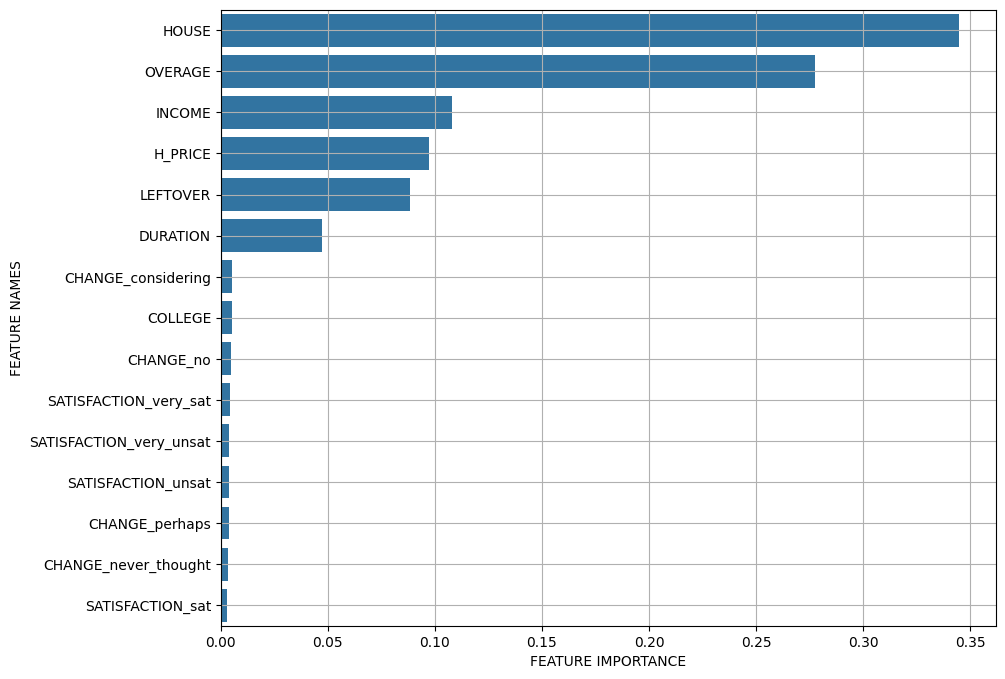

In [13]:
# 최적 모델의 변수 중요도 수치
model_gs.best_estimator_.feature_importances_

# 시각화 함수 호출
plot_feature_importance(model_gs.best_estimator_.feature_importances_, x_train.columns)

## 5. 실습: Carseats 판매량 예측

In [14]:
from sklearn.ensemble import RandomForestRegressor

# 데이터 로딩
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(path)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [15]:
target = 'Sales'
x = data.drop(target, axis=1)
y = data.loc[:, target]

cat_cols = ['ShelveLoc', 'US', 'Urban']

# 가변수화 수행
x = pd.get_dummies(x, columns=cat_cols, drop_first=True)

# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state=20)

In [17]:
# 1. 튜닝 파라미터 정의
params = {
    'n_estimators': range(10, 201, 10),
    'max_depth': range(2, 11)
}

# 2. 모델 선언
model_rf = RandomForestRegressor()

# 3. Grid Search 선언 및 학습
model_gs = GridSearchCV(model_rf, params, cv=5)
model_gs.fit(x_train, y_train)

# 4. 최적 결과 확인
print("최적 파라미터:", model_gs.best_params_)
print("최고 점수 (R2):", model_gs.best_score_)

# 5. 검증 데이터 예측 및 평가 (RMSE, R2)
pred = model_gs.predict(x_val)
from sklearn.metrics import mean_squared_error, r2_score

print("RMSE:", mean_squared_error(y_val, pred)**0.5)
print("R2 Score:", r2_score(y_val, pred))

최적 파라미터: {'max_depth': 10, 'n_estimators': 120}
최고 점수 (R2): 0.6893273200778968
RMSE: 1.774369203114651
R2 Score: 0.6220226971564441
